<a href="https://colab.research.google.com/github/dauvannam1804/Finetune-Vintern1B/blob/main/Fine_tuned_Vintern_1B_v2_for_Vietnamese_Receipt_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fine-tuning Vintern-1B-v2 on 5CD/Viet-Receipt-VQA**

In this notebook, we will fine-tune Vintern-1B by 5CD/Viet-Receipt-VQA an Vietnamese dataset, a new vision language model capable of various tasks, on document question answering for Vietnamese.

Reference: https://internvl.readthedocs.io/en/latest/internvl2.0/finetune.html

Check it more about us: [Fifth Civil Defender - 5CD - AI](https://huggingface.co/5CD-AI)

Let's start by installing the dependencies and loading the dataset.

In [ ]:
!pip install -q datasets flash_attn timm einops peft wandb deepspeed accelerate bitsandbytes decord tensorboardX gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 125.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!git clone https://github.com/5CD-AI/Vintern.git
%cd Vintern

Cloning into 'Vintern'...
remote: Enumerating objects: 2331, done.
remote: Counting objects: 100% (944/944), done.
remote: Compressing objects: 100% (258/258), done.
remote: Total 2331 (delta 723), reused 688 (delta 686), pack-reused 1387
Receiving objects: 100% (2331/2331), 36.31 MiB | 20.30 MiB/s, done.
Resolving deltas: 100% (1421/1421), done.
/content/Vintern


# **Load dataset**

In [ ]:
from datasets import load_dataset, Image
vi_receipt_dataset = load_dataset("5CD-AI/Viet-Receipt-VQA")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/2034 [00:00<?, ? examples/s]

In [ ]:
vi_receipt_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'image', 'description', 'extractions', 'conversations'],
        num_rows: 2034
    })
})

In [ ]:
vi_receipt_dataset['train'][0]

{'id': 443,
 'image': <PIL.Image.Image image mode=RGB size=768x1024>,
 'description': 'Hóa đơn bán hàng của Vincommerce, ngày 14/08/2020, 21:37, mã hóa đơn H:00073344, NVBH:09021213,  gồm 1 mặt hàng là Kem hướng sữa  riêng Vinamilk hộp 450ml với đơn giá 43.800, tổng tiền phải trả 43.800, tiền khách trả 50.000, tiền trả lại 6.200.',
 'extractions': "{'Tên cửa hàng': 'Vincommerce', 'Địa chỉ': 'DA khu DCLB cóc 8, P. Cẩm Sơn, TP. Cẩm Phả, T. Quảng Ninh', 'Số điện thoại': '024.71066866-44561', 'Ngày bán': '14/08/2020', 'Giờ bán': '21:37', 'Số quầy': '001', 'Mã hóa đơn': 'H:00073344', 'NVBH': '09021213', 'Mặt hàng': 'Kem hướng sữa  riêng Vinamilk hộp 450ml', 'Đơn giá': '43.800', 'Số lượng': '1', 'Tổng tiền': '43.800', 'Tổng tiền à giảm': '0', 'Tiền khách trả': '43.800', 'Tiền mặt': '50.000', 'Tiền trả lại': '6.200'}",
 'conversations': [{'role': 'user',
   'content': 'Hóa đơn được xuất tại cửa hàng nào?'},
  {'role': 'assistant',
   'content': 'Hóa đơn được xuất tại cửa hàng Vincommerce.'},


# **Prepare model**

## Download model

Before starting the second fine-tuning, download the pre-trained model is provided.

In [ ]:
!mkdir -p pretrained
%cd pretrained/
# Download 5CD-AI/Vintern-1B-v2 ---- Vision Part:InternViT‑300M‑448px + Language Part: Qwen2‑0.5B‑Instruct
!huggingface-cli download --resume-download --local-dir-use-symlinks False 5CD-AI/Vintern-1B-v2 --local-dir Vintern-1B-v2

/content/Vintern/pretrained
/usr/local/lib/python3.10/dist-packages/huggingface_hub/commands/download.py:132: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Fetching 16 files:   0% 0/16 [00:00<?, ?it/s]Downloading 'conversation.py' to 'Vintern-1B-v2/.huggingface/download/conversation.py.8826fef9f6abfbfb164001acb2cd98dd446e1ed3.incomplete'

README.md: 100% 5.17k/5.17k [00:00<00:00, 8.28MB/s]

conversation.py:   0% 0.00/15.8k [00:00<?, ?B/s]Download complete. Moving file to Vintern-1B-v2/README.md
conversation.py: 100% 15.8k/15.8k [00:00<00:00, 57.9MB/s]
Download complete. Moving file to Vintern-1B-v2/conversation.py

configur

## Test single image

Let's do inference with our dataset first to see how the model performs already with our dataset before fine-tuning. After testing you should clear the gpu (restart session) for next steps.

In [ ]:
#### Do not use flash attention if your device not support

# import json
# with open('pretrained/InternVL2-1B/config.json', 'r') as f:
#     config = json.load(f)
# config["vision_config"]["use_flash_attn"] = False
# with open('pretrained/InternVL2-1B/config.json', 'w') as f:
#     json.dump(config, f)

In [ ]:
import os
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    #check image_file is a path or image
    if isinstance(image_file, str):
        image = Image.open(image_file).convert('RGB')
    else:
        image = image_file
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

In [ ]:
## load pretrained model
model_name = "/content/Vintern/pretrained/Vintern-1B-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)
model = AutoModel.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    trust_remote_code=True
).eval().cuda()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


configuration_internvl_chat.py:   0%|          | 0.00/3.80k [00:00<?, ?B/s]

configuration_intern_vit.py:   0%|          | 0.00/5.55k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v2:
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v2:
- configuration_internvl_chat.py
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_internvl_chat.py:   0%|          | 0.00/15.2k [00:00<?, ?B/s]

modeling_intern_vit.py:   0%|          | 0.00/18.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v2:
- modeling_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


conversation.py:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v2:
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v2:
- modeling_internvl_chat.py
- modeling_intern_vit.py
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


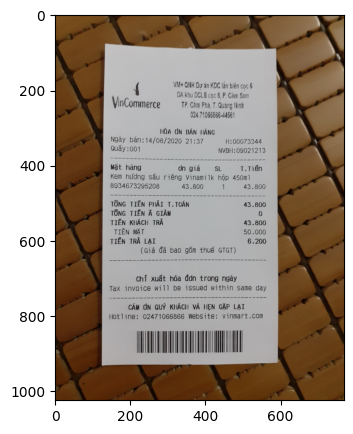

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Trích xuất thông tin hoá đơn trong ảnh.
Assistant: Hoá đơn bán hàng ngày 14/08/2020 lúc 21:37, số hóa đơn H:00073344, NVBH:09021213, mặt hàng Kem hướng sầu riêng Vinamilk hộp 450ml, đơn giá 43.800, số lượng 1, thành tiền 43.800, tổng tiền phải thanh toán 43.800, tổng tiền giảm 0, tiền khách trả 50.000, tiền trả lại 6.200, chỉ xuất hóa đơn trong ngày, tax invoice will be issued within same day, cảm ơn quý khách và hẹn gặp lại, hotline: 02471066866, website: vinmart.com


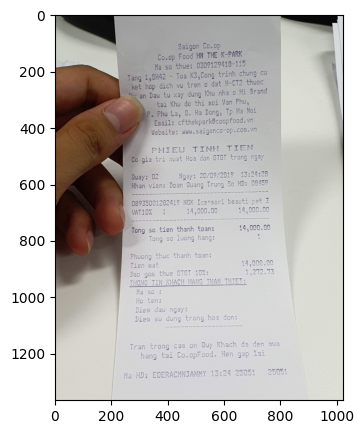

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Trích xuất thông tin hoá đơn trong ảnh.
Assistant: Sài Gòn Co.op
Co.op Food HN THE K-PARK
Mã số thuế: 0309129418-115
Tăng 1, SH42 - Toa K3, Công trình chung cu
kết hợp dịch vụ trên ô đạt H-CT2 thuoc
Dự an Đầu tư xây dựng Khu nhà ở Hi Brand
P. Phu La, Q. Hà Đông, TP Hà Nội
Email: cfthekpark@coopfood.vn
Website: www.saigonco-op.com.vn
PHIẾU TINH TIỀN
Có giá trị xuất Hoa đơn GTGT trong ngày
Quay: 02
Ngày: 20/09/2019 13:24:28
Nhân viên: Doan Quang Trung SO HD: 08459
08935001282419 NGK Icesori beauty pet 3
VAT10% 1 14,000.00
14,000.00
Tổng số tiền thanh toán: 14,000.00
Tổng số lượng hàng: 1
Phương thức thanh toán: 14,000.00
Tiền mặt: 14,000.00
Bao gồm thuế GTGT 10%: 1,272.73
THÔNG TIN KHÁCH HÀNG THAN THIỆT:
Mã số: ...
Họ tên: ...
Điểm đau ngay:
Điểm sử dụng trong hóa đơn:
Trân trọng cảm ơn Quý Khách đã mua hàng tại Co.opFood. Hen gặp lại
Ma HD: EDERACMNJANMY 13:24 25051 25051


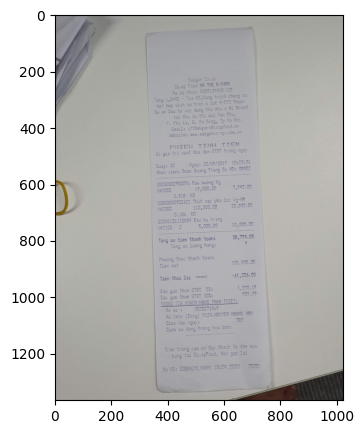

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Trích xuất thông tin hoá đơn trong ảnh.
Assistant: Hoá đơn được xuất ra vào ngày 20/09/2019 lúc 10:23:36, với tổng số tiền thanh toán là 38.774.000 đồng.


In [ ]:
### Test samples
for i in range(3):
    image = vi_receipt_dataset['train'][i]['image']

    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.show()

    pixel_values = load_image(image, max_num=12).to(torch.bfloat16).cuda()
    generation_config = dict(max_new_tokens= 1024, do_sample=False, num_beams = 3, repetition_penalty=2.0)

    question = '<image>\nTrích xuất thông tin hoá đơn trong ảnh.'

    response = model.chat(tokenizer, pixel_values, question, generation_config)
    print(f'User: {question}\nAssistant: {response}')
    print("="*30)

In [ ]:
torch.cuda.empty_cache()

# **Prepare Your Customized Training Data**

In [ ]:
%cd /content/Vintern

/content/Vintern


## Single-Image Data
First you need to create a dataset json file to describe each item of your dataset

For single-image data, we use a **JSONL** file to store the data. Each entry is a dictionary organized in the following format. Note that each entry for single-image data must contain an image field, which is a string.

The path in the image field is relative to the root field. Concatenating the root field and the image field gives the complete path to the image. It is recommended to include width and height information for each data sample for future use.
```
{
  "id": 0,
  "image": "path/to/image.jpg",
  "width": 111,
  "height": 222,
  "conversations": [
    {"from": "human", "value": "<image>\nuser input"},
    {"from": "gpt", "value": "assistant output"},
    {"from": "human", "value": "user input"},
    {"from": "gpt", "value": "assistant output"}
  ]
}
```

Save image to image folder to get image_path to follow format of dataset

In [ ]:
import os
from tqdm import tqdm
FOLDER_IMAGES = "/content/Viet-Receipt-VQA-images"
os.makedirs(FOLDER_IMAGES, exist_ok=True)

In [ ]:

### Save image dataset
for i in tqdm(range(len(vi_receipt_dataset['train']))):
    image = vi_receipt_dataset['train'][i]['image']
    id = vi_receipt_dataset['train'][i]['id']

    #resize 448x448
    image = image.resize((448, 448)) # Just for saving vram
    image.save(f"{FOLDER_IMAGES}/{id}.jpg")

100%|██████████| 2034/2034 [00:47<00:00, 42.47it/s]


Format each item data follow format above

In [ ]:
import json

all_data = []

for item in tqdm(vi_receipt_dataset['train']):
    # Just 500 items for example
    if len(all_data) >= 500:
        break
    id = item['id']
    image = f"{FOLDER_IMAGES}/{item['id']}.jpg"
    width = item['image'].width
    height = item['image'].height
    conversations = [
            {"from": "human", "value": '<image>\nTrích xuất thông tin hoá đơn trong ảnh.'},
            {"from": "gpt", "value": str(item["extractions"])}
        ]
    data = {
        "id": id,
        "image": image,
        "width": width,
        "height": height,
        "conversations": conversations
    }
    all_data.append(data)

print(len(all_data))
print(all_data[0:5])

 25%|██▍       | 500/2034 [00:02<00:08, 182.29it/s]

500
[{'id': 443, 'image': '/content/Viet-Receipt-VQA-images/443.jpg', 'width': 768, 'height': 1024, 'conversations': [{'from': 'human', 'value': '<image>\nTrích xuất thông tin hoá đơn trong ảnh.'}, {'from': 'gpt', 'value': "{'Tên cửa hàng': 'Vincommerce', 'Địa chỉ': 'DA khu DCLB cóc 8, P. Cẩm Sơn, TP. Cẩm Phả, T. Quảng Ninh', 'Số điện thoại': '024.71066866-44561', 'Ngày bán': '14/08/2020', 'Giờ bán': '21:37', 'Số quầy': '001', 'Mã hóa đơn': 'H:00073344', 'NVBH': '09021213', 'Mặt hàng': 'Kem hướng sữa  riêng Vinamilk hộp 450ml', 'Đơn giá': '43.800', 'Số lượng': '1', 'Tổng tiền': '43.800', 'Tổng tiền à giảm': '0', 'Tiền khách trả': '43.800', 'Tiền mặt': '50.000', 'Tiền trả lại': '6.200'}"}]}, {'id': 7, 'image': '/content/Viet-Receipt-VQA-images/7.jpg', 'width': 1024, 'height': 1366, 'conversations': [{'from': 'human', 'value': '<image>\nTrích xuất thông tin hoá đơn trong ảnh.'}, {'from': 'gpt', 'value': "{'Tên cửa hàng': 'Saigon Co.op', 'Chi nhánh': 'Co.op Food HN THE K-PARK', 'Mã số thu

In [ ]:
### Write JSONL line
with open('/content/Vintern/internvl_chat/shell/data/viet-receipt-vqa.jsonl', 'w', encoding='utf-8') as f:
    for data in tqdm(all_data):
        f.write(json.dumps(data, ensure_ascii=False) + '\n')

100%|██████████| 500/500 [00:00<00:00, 51275.11it/s]


## Create meta file to manage the meta information of all datasets

After downloading the pre-trained model, prepare your customized SFT (Supervised Fine-Tuning) data. Create a JSON file in `internvl_chat/shell/data/` similar to [this example](https://github.com/OpenGVLab/InternVL/blob/main/internvl_chat/shell/data/internvl_1_2_finetune.json)

The format for the JSON file should be:

```
{
  "your-custom-dataset-1": {
    "root": "path/to/the/image/",
    "annotation": "path/to/the/jsonl/annotation",
    "data_augment": false,
    "repeat_time": 1,
    "length": "number of your data"
  },
  ...
}```



In [ ]:
metadata_datasets = {
  "vi-receipt-vqa": {
    "root": "/content/Viet-Receipt-VQA-images",
    "annotation": "/content/Vintern/internvl_chat/shell/data/viet-receipt-vqa.jsonl",
    "data_augment": False,
    "repeat_time": 1,
    "length": 500
  }
}

with open('/content/Vintern/internvl_chat/shell/data/custom_fintune_datasets.json', 'w', encoding='utf-8') as f:
    json.dump(metadata_datasets, f, ensure_ascii=False, indent=4)


# Training

## LoRA fine-tuning

Fine-tune the pre-trained models using either the script for training the [full LLM](https://internvl.readthedocs.io/en/latest/internvl2.0/finetune.html#:~:text=script%20for%20training%20the%20full%20LLM) or the script for training the [LoRA adapter](https://github.com/OpenGVLab/InternVL/blob/main/internvl_chat/shell/internvl2.0/2nd_finetune/internvl2_1b_qwen2_0_5b_dynamic_res_2nd_finetune_lora.sh), depending on your available GPU resources.

Before fine-tuning, set the --meta_path to the path of the JSON file you created in the previous step. The default pre-trained model path in these shell scripts is ./pretrained/InternVL2-1B.

In the default settings, I have frozen the visual encoder. You can unfreeze it if needed. Generally, unfreezing the visual encoder will result in better performance.



Edit file `InternVL/internvl_chat/shell/internvl2.0/2nd_finetune/internvl2_1b_qwen2_0_5b_dynamic_res_2nd_finetune_lora.sh` for train LoRA LLM follow example below

In [ ]:
train_bash_content = '''set -x

GPUS=${GPUS:-1}
BATCH_SIZE=${BATCH_SIZE:-1}
PER_DEVICE_BATCH_SIZE=${PER_DEVICE_BATCH_SIZE:-1}
GRADIENT_ACC=$((BATCH_SIZE / PER_DEVICE_BATCH_SIZE / GPUS))


export PYTHONPATH="${PYTHONPATH}:$(pwd)"
export MASTER_PORT=34229
export TF_CPP_MIN_LOG_LEVEL=3
export LAUNCHER=pytorch

OUTPUT_DIR='/content/work_dirs/internvl_chat_v2_0/Vintern_1B_v2_finetune_lora_viet_receipt_vqa'

if [ ! -d "$OUTPUT_DIR" ]; then
  mkdir -p "$OUTPUT_DIR"
fi

# number of gpus: 2
# batch size per gpu: 4
# gradient accumulation steps: 2
# total batch size: 16
# epoch: 1
torchrun \
  --nnodes=1 \
  --node_rank=0 \
  --master_addr=127.0.0.1 \
  --nproc_per_node=${GPUS} \
  --master_port=${MASTER_PORT} \
  internvl/train/internvl_chat_finetune.py \
  --model_name_or_path "/content/Vintern/pretrained/Vintern-1B-v2" \
  --conv_style "Hermes-2" \
  --output_dir ${OUTPUT_DIR} \
  --meta_path "/content/Vintern/internvl_chat/shell/data/custom_fintune_datasets.json" \
  --overwrite_output_dir True \
  --force_image_size 448 \
  --max_dynamic_patch 6 \
  --down_sample_ratio 0.5 \
  --drop_path_rate 0.0 \
  --freeze_llm True \
  --freeze_mlp True \
  --freeze_backbone True \
  --use_llm_lora 16 \
  --vision_select_layer -1 \
  --dataloader_num_workers 4 \
  --bf16 True \
  --num_train_epochs 1 \
  --per_device_train_batch_size ${PER_DEVICE_BATCH_SIZE} \
  --gradient_accumulation_steps ${GRADIENT_ACC} \
  --evaluation_strategy "no" \
  --save_strategy "steps" \
  --save_steps 500 \
  --save_total_limit 2 \
  --learning_rate 4e-5 \
  --weight_decay 0.01 \
  --warmup_ratio 0.03 \
  --lr_scheduler_type "cosine" \
  --logging_steps 10 \
  --max_seq_length 700 \
  --do_train True \
  --grad_checkpoint True \
  --group_by_length True \
  --dynamic_image_size True \
  --use_thumbnail True \
  --ps_version 'v2' \
  --deepspeed "zero_stage1_config.json" \
  --report_to "tensorboard" \
  2>&1 | tee -a "${OUTPUT_DIR}/training_log.txt"
'''

In [ ]:
with open("/content/Vintern/internvl_chat/shell/internvl2.0/2nd_finetune/internvl2_1b_qwen2_0_5b_dynamic_res_2nd_finetune_lora.sh", "w") as text_file:
    text_file.write(train_bash_content)

Let's go training. It take about just 15 minutes with T4

In [ ]:
%cd /content/Vintern/internvl_chat
!sh shell/internvl2.0/2nd_finetune/internvl2_1b_qwen2_0_5b_dynamic_res_2nd_finetune_lora.sh

/content/Vintern/internvl_chat
+ GPUS=1
+ BATCH_SIZE=1
+ PER_DEVICE_BATCH_SIZE=1
+ GRADIENT_ACC=1
+ pwd
+ export PYTHONPATH=/env/python:/content/Vintern/internvl_chat
+ export MASTER_PORT=34229
+ export TF_CPP_MIN_LOG_LEVEL=3
+ export LAUNCHER=pytorch
+ OUTPUT_DIR=/content/work_dirs/internvl_chat_v2_0/internvl2_1b_qwen2_0_5b_dynamic_res_2nd_finetune_lora_viet_receipt_vqa_new
+ [ ! -d /content/work_dirs/internvl_chat_v2_0/internvl2_1b_qwen2_0_5b_dynamic_res_2nd_finetune_lora_viet_receipt_vqa_new ]
+ mkdir -p /content/work_dirs/internvl_chat_v2_0/internvl2_1b_qwen2_0_5b_dynamic_res_2nd_finetune_lora_viet_receipt_vqa_new
+ torchrun --nnodes=1 --node_rank=0 --master_addr=127.0.0.1 --nproc_per_node=1 --master_port=34229 internvl/train/internvl_chat_finetune.py --model_name_or_path /content/Vintern/pretrained/Vintern-1B-v2 --conv_style Hermes-2 --output_dir /content/work_dirs/internvl_chat_v2_0/internvl2_1b_qwen2_0_5b_dynamic_res_2nd_finetune_lora_viet_receipt_vqa_new --meta_path /content/Vi

In [ ]:
import torch
torch.cuda.empty_cache()

## Merging LoRA Weights
After evaluating the fine-tuned model, you may want to merge the LoRA weights back into the original InternVL2 model. Follow these steps to accomplish this.

Use the provided script to merge the LoRA weights into the base model. The script takes two arguments: the input path of the fine-tuned model and the output path for the merged model.

`python tools/merge_lora.py <input_path> <output_path>`

In [ ]:
merge_lora_content = '''import torch
import sys
sys.path.append("/content/Vintern/internvl_chat")
from internvl.model.internvl_chat import InternVLChatModel
from transformers import AutoTokenizer
import argparse

argparse = argparse.ArgumentParser()
argparse.add_argument("input_path", type=str, help="Path to the input model")
argparse.add_argument("output_path", type=str, help="Path to the output model")
args = argparse.parse_args()

print("Loading model...")
model = InternVLChatModel.from_pretrained(
    args.input_path, low_cpu_mem_usage=True, torch_dtype=torch.bfloat16).eval()
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(args.input_path, trust_remote_code=True)

if model.config.use_backbone_lora:
    model.vision_model.merge_and_unload()
    model.vision_model = model.vision_model.model
    model.config.use_backbone_lora = 0
if model.config.use_llm_lora:
    model.language_model.merge_and_unload()
    model.language_model = model.language_model.model
    model.config.use_llm_lora = 0

print("Saving model...")
model.save_pretrained(args.output_path)
print("Saving tokenizer...")
tokenizer.save_pretrained(args.output_path)
print("Done!")
'''

with open("/content/Vintern/internvl_chat/tools/merge_lora.py", "w") as text_file:
    text_file.write(merge_lora_content)

In [ ]:
### If could not import internvl edit add
### import sys
### sys.path.append("/content/Vintern/internvl_chat")

%cd /content/Vintern/internvl_chat
!python tools/merge_lora.py /content/work_dirs/internvl_chat_v2_0/Vintern_1B_v2_finetune_lora_viet_receipt_vqa \
                            /content/work_dirs/internvl_chat_v2_0/Vintern_1B_v2_finetune_lora_viet_receipt_vqa_merge

/content/Vintern/internvl_chat
Loading model...
trainable params: 8,798,208 || all params: 638,462,080 || trainable%: 1.3780
Loading tokenizer...
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Saving model...
[2024-08-09 09:36:00,268] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  NVIDIA Inference is only supported on Ampere and newer architectur

## Wrapping into AutoModel
After merging the LoRA weights, you can wrap the fine-tuned InternVL2 model into an AutoModel for easier inference or deployment.

First, copy all the Python scripts from the original InternVL2-2B directory to the new merged model directory:



In [ ]:
!cp /content/Vintern/pretrained/Vintern-1B-v2/*.py \
    /content/work_dirs/internvl_chat_v2_0/Vintern_1B_v2_finetune_lora_viet_receipt_vqa_merge

Next, copy the config.json file from the original InternVL2-1B directory to the new merged model directory:

In [ ]:
!cp /content/Vintern/pretrained/Vintern-1B-v2/config.json \
    /content/work_dirs/internvl_chat_v2_0/Vintern_1B_v2_finetune_lora_viet_receipt_vqa_merge

# Inference with fintuned model

After copying the necessary files, you can now load and use the fine-tuned InternVL2 model with AutoModel for inference

In [ ]:
import os
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    #check image_file is a path or image
    if isinstance(image_file, str):
        image = Image.open(image_file).convert('RGB')
    else:
        image = image_file
    image = image.resize((input_size, input_size))

    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

In [ ]:
## load pretrained model
model_name = "/content/work_dirs/internvl_chat_v2_0/Vintern_1B_v2_finetune_lora_viet_receipt_vqa_merge"

model = AutoModel.from_pretrained(model_name,
                                  torch_dtype=torch.bfloat16,
                                  low_cpu_mem_usage=True,
                                  trust_remote_code=True).eval().cuda()
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)


A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v2:
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v2:
- configuration_internvl_chat.py
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v2:
- modeling_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v2:
- conversation.py
. Make

In [ ]:
!gdown https://drive.google.com/drive/folders/17FFnVEgJjWCgKlHzppYOeXfBRQIV--3D?usp=sharing --folder -O /content/test

Retrieving folder contents
Processing file 1zZK63yoQUbD6WR1Sbyk_1eM-WqnUkfcL hoa_don_1.jpg
Processing file 1NAGuAOmFXxEHaKrWDp7Ib51vAeE88u3z hoa_don_2.jpg
Processing file 11_Zo_odRMy5vun--AxsGcN3DNAM-Xj7l hoa_don_3.jpg
Processing file 1bh_DbKNQRi-JP2cQLFtFZyUwLlpWuxcu hoa_don_4.jpg
Processing file 1xGrvsVpTuFL6pgTH-qR9NWodVayuhZOS hoa_don_5.jpg
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1zZK63yoQUbD6WR1Sbyk_1eM-WqnUkfcL
To: /content/test/hoa_don_1.jpg
100% 191k/191k [00:00<00:00, 125MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NAGuAOmFXxEHaKrWDp7Ib51vAeE88u3z
To: /content/test/hoa_don_2.jpg
100% 143k/143k [00:00<00:00, 153MB/s]
Downloading...
From: https://drive.google.com/uc?id=11_Zo_odRMy5vun--AxsGcN3DNAM-Xj7l
To: /content/test/hoa_don_3.jpg
100% 178k/178k [00:00<00:00, 143MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bh_DbKNQRi-JP2cQLFtFZyUwLlp

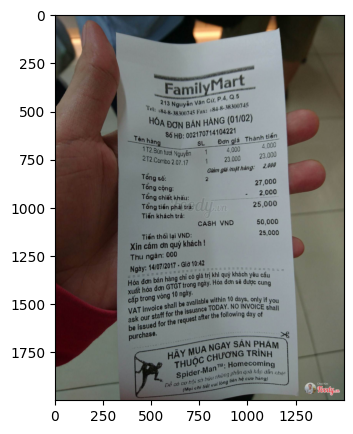

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Trích xuất thông tin hoá đơn trong ảnh.
Assistant: {'Tên cửa hàng': 'FamilyMart', 'Địa chỉ': '213 Nguyễn Văn Cừ, P.4, Q.5', 'Số điện thoại': '0867 380747', 'Số hóa đơn': '00102', 'Ngày bán': '14/04/2017', 'Giờ bán': '10:42', 'Tên hàng': '112 Bún tươi ngon 1L', 'Số lượng': '1', 'Đơn giá': '27.000', 'Thành tiền': '27.000', 'Tổng số': '2', 'Tổng cộng': '2.000', 'Tiền khách trả': '25.000', 'Tiền mặt': '25.000', 'Tiền thừa': '0', 'Thu ngân': '14/04/2017', 'Giờ ngân': '10:42'}


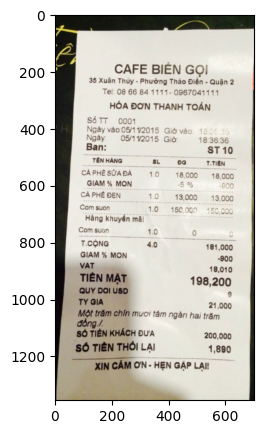

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Trích xuất thông tin hoá đơn trong ảnh.
Assistant: {'Tên cửa hàng': 'CAFE BIÊN GỌI', 'Địa chỉ': '35 Xuân Thủy - Phường Thảo Điền - Quận 2', 'Số điện thoại': '08 66 84 1111 - 0967041111', 'Số hóa đơn': '0001', 'Ngày vào': '05/11/2015', 'Giờ vào': '18:36:36', 'Ngày': '05/11/2015', 'Giờ': '18:36:36', 'Tên hàng': ['Cà phê đá', 'Cà phê % món', 'Cam Đen', 'Hàng khuyến mãi'], 'Số lượng': [1.0, 1.0, 1.0, 1.0], 'Đơn giá': [150.0, 150.0, 150.0, 150.0], 'Thành tiền': [150.0, 150.0, 150.0, 150.0], 'Tổng cộng': '198.200', 'Tiền mặt': '198.200', 'VAT': '0', 'Tiền trả lại': '200.000', 'Số tiền khách đưa': '1.890'}


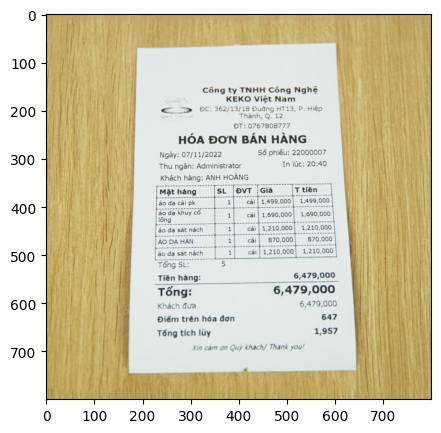

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Trích xuất thông tin hoá đơn trong ảnh.
Assistant: {'Tên công ty': 'Công ty TNHH Công Nghệ', 'Địa chỉ': 'ĐC: 362 Thăng Long, P. Hiệp Phú, TP. Hiệp Phú, Quảng Ninh', 'Số điện thoại': '0768.008777', 'Số phiếu': '220000007', 'Ngày': '07/11/2022', 'Giờ': '20:40', 'Thu ngân': 'Administrator', 'Khách hàng': 'ANH HOÀNG', 'Mặt hàng': [{'Tên sản phẩm': 'sữa da chép', 'Số lượng': 1, 'Đơn vị tính': 'cái', 'Giá': '1490.000', 'Thành tiền': '1490.000'}, {'Tên sản phẩm': 'sữa da khuất có', 'Số lượng': 1, 'Đơn vị tính': 'cái', 'Giá': '1490.000', 'Thành tiền': '1490.000'}, {'Tên sản phẩm': 'ADG DA HẠN', 'Số lượng': 1, 'Đơn vị tính': 'cái', 'Giá': '1210.000', 'Thành tiền': '1210.000'}], 'Tổng': '6479.000', 'Tổng cộng': '6479.000', 'Tổng tiền hàng': '6479.000', 'Tiền khách đưa': '6479.000', 'Tổng điểm trên hóa đơn': '1,957', 'Tổng tích lũy': '1,957'}


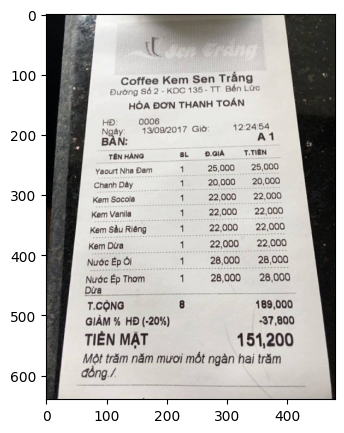

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Trích xuất thông tin hoá đơn trong ảnh.
Assistant: {'Tên cửa hàng': 'Coffee Kem Sen Trắng', 'Địa chỉ': 'Đường số 2 - KDC 135 - TT Bến Lức', 'Số hoá đơn': '0006', 'Ngày': '13/08/2017', 'Giờ': '12:24:54', 'Tên hàng': ['Yaourt Nha Dam', 'Chanh Dây', 'Kem Socola', 'Kem Vanilia', 'Kem Sầu Riềng', 'Kem Dừa', 'Nước Ép Ôi', 'Nước Ép Thơm'], 'Số lượng': [1, 1, 1, 1, 1, 1, 1, 1], 'Đơn giá': [25000, 20000, 22000, 22000, 22000, 22000, 28000, 28000], 'Thành tiền': [25000, 20000, 22000, 22000, 22000, 22000, 28000, 28000], 'Tổng cộng': '189.000', 'Giảm % HD': '-20%', 'Tiền mặt': '151.200'}


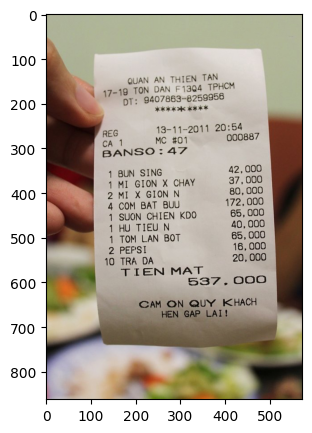

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Trích xuất thông tin hoá đơn trong ảnh.
Assistant: {'Ngày': '13-11-2011', 'Giờ': '20:54', 'Số hoá đơn': '000887', 'Tên món 1': 'BUN SING X CHAY', 'Số lượng món 1': '1', 'Đơn giá món 1': '42.000', 'Tên món 2': 'MI GIÒN X CHAY', 'Số lượng món 2': '1', 'Đơn giá món 2': '80.000', 'Tên món 3': 'CƠM BẠT BƯU', 'Số lượng món 3': '1', 'Đơn giá món 3': '65.000', 'Tên món 4': 'SUON CHIEN KDO', 'Số lượng món 4': '1', 'Đơn giá món 4': '65.000', 'Tên món 5': 'HU TIÊU N', 'Số lượng món 5': '1', 'Đơn giá món 5': '65.000', 'Tên món 6': 'TOM LAN BOT', 'Số lượng món 6': '1', 'Đơn giá món 6': '65.000', 'Tiền khách trả': '537.000', 'Trả lại': '20.000'}


In [ ]:
### Test samples
test_folder = '/content/test'
for filename in os.listdir(test_folder):
    image_path = os.path.join(test_folder, filename)
    image = Image.open(image_path).convert('RGB')

    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.show()

    pixel_values = load_image(image_path, max_num=12).to(torch.bfloat16).cuda()
    generation_config = dict(max_new_tokens= 1024, do_sample=False, num_beams = 3, repetition_penalty=2.0)

    question = '<image>\nTrích xuất thông tin hoá đơn trong ảnh.'

    response = model.chat(tokenizer, pixel_values, question, generation_config)
    print(f'User: {question}\nAssistant: {response}')
    print("="*30)

This guide provided a step-by-step approach to enhancing the InternVL2 model on Viet-Receipt-VQA using LoRA fine-tuning. By following these instructions, you should be able to achieve improved performance in extraction tasks.  Viet-Receipt-VQA is just one example; you can replace it with other downstream datasets for fine-tuning. Happy fine-tuning!

DON'T WORRY ABOUT IT! WE HERE FOR YOU <3

You could find more Vietnamese datasets here.

Check it more about us: [Fifth Civil Defender - 5CD - AI](https://huggingface.co/5CD-AI)

